In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_rid_of_nan(h):
    for y in range(h.shape[0]):
        for x in range(h.shape[1]):
            if h[y][x] != h[y][x]:
                h[y][x] = 0
    return h

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
data = np.load('drive/MyDrive/map_pose_cmd_X1_04_01_2x2_centered_base_footprint.npz')
X = data['heightmaps']
X = get_rid_of_nan(X)
y = data['robot_pose'][:,3:5]
Xtr,Xts,ytr,yts = train_test_split(X,y, train_size=0.66)
Xtr = torch.from_numpy(Xtr)
ytr = torch.from_numpy(ytr)
Xts = torch.from_numpy(Xts)
yts = torch.from_numpy(yts)
print(Xtr.shape)
print(ytr.shape)

torch.Size([231, 100])
torch.Size([231, 2])


In [ ]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.layer1 = nn.Linear(10*10, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 2)

    def forward(self, input):
        x = self.dropout(self.relu(self.layer1(input)))
        x = self.dropout(self.relu(self.layer2(x)))
        output = self.layer3(x)
        return output

In [ ]:
from torch import nn
import math

class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.relu = nn.LeakyReLU(0.01, inplace=True)
        self.conv1 = nn.Conv2d(1, 16, [2, 2], bias=False)
        self.conv2 = nn.Conv2d(16, 32, [2, 2], bias=False)
        self.lin1 = nn.Linear(32*8*8, 128)
        self.lin2 = nn.Linear(128, 2)

    def forward(self, input):
        scale = int(math.sqrt(input.shape[0]))
        input = np.reshape(input, (scale,scale))
        input = np.expand_dims(input, 0)
        input = np.expand_dims(input, 0)
        input = torch.from_numpy(input)
        x = self.relu(self.conv1(input))
        x = self.relu(self.conv2(x))
        x = x.view(-1,32*8*8)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

In [ ]:
net = NeuralNetwork()
print(net)

In [ ]:
net = ConvNeuralNetwork()
print(net)

ConvNeuralNetwork(
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv1): Conv2d(1, 16, kernel_size=[2, 2], stride=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=[2, 2], stride=(1, 1), bias=False)
  (lin1): Linear(in_features=2048, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
import datetime
import tensorflow as tf
from tensorflow import summary
%load_ext tensorboard

current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)



In [ ]:
@tf.function
def my_func(step,loss):
  with train_summary_writer.as_default():
    tf.summary.scalar("loss",loss,step)

In [ ]:
#train nn

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

net.train()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0)

EPOCH = 1000
step = 0
optimizer.zero_grad()

n = EPOCH * Xtr.shape[0]
losses = np.zeros(n)
steps = np.arange(1,n,1)

for epoch in range(EPOCH):
  epoch_train_loss = 0
  for x_,y_ in zip(Xtr,ytr):
    pred = net(x_.float())
    loss = loss_fn(pred[0], y_.float())
    epoch_train_loss += loss.item()
    writer.add_scalar("Loss/train", loss, epoch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    writer.add_scalar('Loss/train', loss.item(), step)
    losses[step] = loss.item()
    step += 1
    #my_func(step,loss.item())

  if (epoch+1) % 50 == 0:
    print("epoch:",epoch)
    print("loss:",epoch_train_loss)

writer.close()

epoch: 0
loss: 4.0473662944859825
epoch: 50
loss: 2.3393428023950946
epoch: 100
loss: 0.8326189860363229
epoch: 150
loss: 0.4987275370494899
epoch: 200
loss: 0.4067055977497205
epoch: 250
loss: 0.37295107754835044
epoch: 300
loss: 0.3527610476785412
epoch: 350
loss: 0.335955757132524
epoch: 400
loss: 0.3207383934245627
epoch: 450
loss: 0.30674498843654874
epoch: 500
loss: 0.29383027905169
epoch: 550
loss: 0.2819055503707659
epoch: 600
loss: 0.27089197720022185
epoch: 650
loss: 0.26073397709498636
epoch: 700
loss: 0.25136590241923074
epoch: 750
loss: 0.24271305216825567
epoch: 800
loss: 0.23471633951933768
epoch: 850
loss: 0.22731393231981656
epoch: 900
loss: 0.22044373232938597
epoch: 950
loss: 0.21404498277746598


IndexError: ignored

In [ ]:
losses = losses[0:230999]

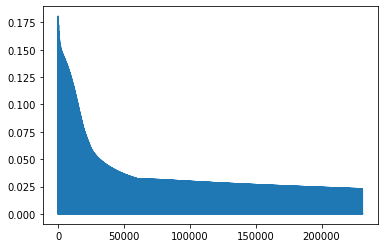

In [ ]:
import matplotlib.pyplot as plt
plt.plot(steps,losses)

In [ ]:
%tensorboard --logdir logs/tensorboard

In [ ]:
torch.save(net.state_dict(), 'drive/MyDrive/convnet_state_with_dropout')

In [ ]:
def get_base(y,p):
    if y*p < 0:
        return 2 * abs(y) + abs(p)
    return max(abs(y), abs(p))

def evaluate(pred,y):
    err = y - pred
    max_value = np.maximum(np.abs(y), np.abs(pred))
    base_value = np.zeros(y.shape)
    for i, y_, p_ in zip(range(y.shape[0]), y, pred):
        roll = get_base(y_[0],p_[0])
        pitch = get_base(y_[1],p_[1])
        base_value[i] = [roll, pitch]
    rel_err = np.abs(err/base_value)
    rel_err_mean = np.mean(rel_err, axis=0)
    err_mean = np.mean(np.abs(err),axis=0)
    value_mean = np.mean(np.abs(y),axis=0)
    print("rellative_err_mean:",rel_err_mean) # mean(err / max(abs(y),abs(y_pred)))
    print("errors mean:",np.round(np.rad2deg(err_mean), decimals=2))
    print("values mean:",np.round(np.rad2deg(value_mean), decimals=2))
    return err, pred


In [ ]:
def predict(X,y,label="data"):
  #conv
  pred = []
  for x in X:
    pred.append(net(x.float()))
  pred = torch.vstack(pred)
  loss = loss_fn(pred, y)
  y_pred = pred.detach().numpy()
  print(label,"data:")
  e,p = evaluate(y_pred, y.numpy())
  return e,p

In [ ]:
etr,ptr = predict(Xtr, ytr, "TRAIN")

TRAIN data:
rellative_err_mean: [0.29771175 0.22256451]
errors mean: [1.05 0.99]
values mean: [3.69 6.02]


In [ ]:
ets,pts = predict(Xts, yts, "TEST")

TEST data:
rellative_err_mean: [0.30390841 0.26019697]
errors mean: [1.   1.05]
values mean: [3.55 5.7 ]


# New Section

In [ ]:
data = np.load('drive/MyDrive/map_pose_cmd_X2_23b48289_2x2_centered_base_footprint.npz')
X2 = data['heightmaps']
X2 = get_rid_of_nan(X2)
y2 = data['robot_pose'][:,3:5]
X2 = torch.from_numpy(X2)
y2 = torch.from_numpy(y2)

In [ ]:
e2,p2 = predict(X2, y2, "DIFF DATA SET")

DIFF DATA SET data:
rellative_err_mean: [0.32614138 0.25799299]
errors mean: [1.27 1.24]
values mean: [4.53 6.44]


In [ ]:
pred = net(Xtr.float())
loss = loss_fn(pred, ytr)
y_pred = pred.detach().numpy()
ytr_np = ytr.numpy()
print("TRAIN data:")
e,p = evaluate(y_pred, ytr_np)

In [ ]:
pred = net(Xts.float())
loss = loss_fn(pred, yts)
y_pred = pred.detach().numpy()
yts_np = yts.numpy()
print("TEST data:")
e,p = evaluate(y_pred, yts_np)

TEST data:
rellative_err_mean: [0.31406176 0.20501933]
errors mean: [1.31 1.25]
values mean: [3.79 6.67]


In [ ]:
pred = net(X2.float())
loss = loss_fn(pred, y2)
y_pred = pred.detach().numpy()
y2_np = y2.numpy()
print("DIFF data:")
e,p = evaluate(y_pred, y2_np)

DIFF data:
rellative_err_mean: [0.36649132 0.3016219 ]
errors mean: [1.59 1.59]
values mean: [4.53 6.44]
